In [ ]:
# get rid of some chemprop warnings
# import warnings

# warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import os

import pandas as pd

# load the data
df = pd.read_csv('/home/s2861704/ppk/test_kin/prep_storage/K200_EGFR_TEST.csv')

display(df.head())

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,Activity_class,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD,Classification
0,AAAAZQPHATYWOK_on_P00533_WT,High,ChEMBL31;Sharma2016;Sharma2016,ChEMBL31.compound.33854;4277046;4277046,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,AAAAZQPHATYWOK,AAAAZQPHATYWOK-UHFFFAOYSA-N,InChI=1S/C32H29ClN6O3S/c1-4-41-28-16-25-22(15-...,"""AuxInfo=1/1/N:1,17,18,2,34,33,14,35,32,13,38,...",P00533_WT,...,NaN,=,6.730; 6.726; 6.063,6.506,0.313,0.222,3.0,6.726,0.004,Enzyme->Kinase->Protein Kinase->TK protein kin...
1,AAEPFBULPJOZCS_on_P00533_WT,High,Sharma2016,10064954,C=CC(=O)Nc1cccc(-n2c(=O)cc(C)c3cnc(Nc4cn(C)nc4...,AAEPFBULPJOZCS,AAEPFBULPJOZCS-UHFFFAOYSA-N,InChI=1S/C22H18F3N7O2/c1-4-17(33)27-13-6-5-7-1...,"""AuxInfo=1/1/N:1,16,25,2,8,7,9,14,34,33,23,15,...",P00533_WT,...,NaN,=,7.276,7.276,0.000,0.000,1.0,7.276,0.000,Enzyme->Kinase->Protein Kinase->TK protein kin...
2,AAFHSECTTHOVFV_on_P00533_WT,High,Sharma2016,4486432,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N(c1cccc(N)...,AAFHSECTTHOVFV,AAFHSECTTHOVFV-UHFFFAOYSA-N,InChI=1S/C25H30N8O2/c1-30-9-11-32(12-10-30)19-...,"""AuxInfo=1/1/N:32,14,1,23,22,24,26,25,30,33,29...",P00533_WT,...,NaN,=,6.321; 5.311; 4.952,5.528,0.580,0.410,3.0,5.311,0.359,Enzyme->Kinase->Protein Kinase->TK protein kin...
3,AAGKMGNYUYCEPD_on_P00533_WT,High,ChEMBL31,ChEMBL31.compound.183555,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,AAGKMGNYUYCEPD,AAGKMGNYUYCEPD-UHFFFAOYSA-N,InChI=1S/C23H19ClN6O2S/c1-14(31)25-8-10-30-9-7...,"""AuxInfo=1/1/N:1,22,21,23,30,29,9,5,8,6,15,26,...",P00533_WT,...,NaN,=,8.540,8.540,0.000,0.000,1.0,8.540,0.000,Enzyme->Kinase->Protein Kinase->TK protein kin...
4,AAHKGRWRYBCWDL_on_P00533_WT,High,Sharma2016,4358384,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,AAHKGRWRYBCWDL,AAHKGRWRYBCWDL-UHFFFAOYSA-N,InChI=1S/C19H23N5O2/c1-3-26-14-9-8-12(10-15(14...,"""AuxInfo=1/1/N:1,7,2,15,16,14,17,25,26,8,23,9,...",P00533_WT,...,NaN,=,5.854,5.854,0.000,0.000,1.0,5.854,0.000,Enzyme->Kinase->Protein Kinase->TK protein kin...


In [2]:
# pivot the dataframe to have the accession as columns
df = df.pivot(index="SMILES", columns="accession", values="pchembl_value_Mean")
#df.columns.name = None
df.reset_index(inplace=True)
print(df.columns)

display(df.head())
#Teams message + delete smiles

Index(['SMILES', 'P00533', 'P04626', 'P17948', 'P35916', 'P35968', 'Q15303'], dtype='object', name='accession')


accession,SMILES,P00533,P04626,P17948,P35916,P35968,Q15303
0,Brc1cc2c(NCc3ccccc3)ncnc2s1,6.62,NaN,NaN,NaN,NaN,NaN
1,Brc1cc2c(NCc3ccccn3)ncnc2s1,5.10,NaN,NaN,NaN,NaN,NaN
2,Brc1cc2c(NCc3cccs3)ncnc2s1,5.86,NaN,NaN,NaN,NaN,NaN
3,Brc1cc2c(NCc3ccncc3)ncnc2s1,5.41,NaN,NaN,NaN,NaN,NaN
4,Brc1cc2c(Nc3ccccc3)ncnc2s1,7.10,NaN,NaN,NaN,NaN,NaN


In [3]:
# print(len(df))
# max_Nans = len(df) - 30
# print(max_Nans)

In [4]:
# df_noempty = df
# df_noempty = df_noempty.drop(list(df.columns[df.isna().sum() > max_Nans]), axis=1)
# df = df_noempty.copy()
# display(df)

In [5]:
column_list = list(df.columns)
print (column_list)

['SMILES', 'P00533', 'P04626', 'P17948', 'P35916', 'P35968', 'Q15303']


In [6]:
del column_list[0:1]
print(column_list)

['P00533', 'P04626', 'P17948', 'P35916', 'P35968', 'Q15303']


In [7]:
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer

target_props = []
for target in column_list:
    target_props.append({'name': target, 'task': "REGRESSION"})

In [8]:
print(target_props)

[{'name': 'P00533', 'task': 'REGRESSION'}, {'name': 'P04626', 'task': 'REGRESSION'}, {'name': 'P17948', 'task': 'REGRESSION'}, {'name': 'P35916', 'task': 'REGRESSION'}, {'name': 'P35968', 'task': 'REGRESSION'}, {'name': 'Q15303', 'task': 'REGRESSION'}]


In [9]:
dataset = QSPRDataset(
    name="ChempropMTTestDataset",
    df=df,
    target_props=target_props,
    store_dir="/home/s2861704/ppk/test_kin/test_output/MT/data",
    random_state=42,
    drop_empty=False,
    overwrite=True
)

dataset.getDF()

accession,SMILES,P00533,P04626,P17948,P35916,P35968,Q15303,QSPRID,P00533_original,P04626_original,P17948_original,P35916_original,P35968_original,Q15303_original
QSPRID,,,,,,,,,,,,,,
ChempropMTTestDataset_00000,Brc1cc2c(NCc3ccccc3)ncnc2s1,6.620,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00000,6.620,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00001,Brc1cc2c(NCc3ccccn3)ncnc2s1,5.100,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00001,5.100,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00002,Brc1cc2c(NCc3cccs3)ncnc2s1,5.860,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00002,5.860,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00003,Brc1cc2c(NCc3ccncc3)ncnc2s1,5.410,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00003,5.410,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00004,Brc1cc2c(Nc3ccccc3)ncnc2s1,7.100,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00004,7.100,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ChempropMTTestDataset_13855,c1csc(-c2n[nH]c3c2Cc2ccccc2-3)c1,NaN,NaN,NaN,NaN,6.03,NaN,ChempropMTTestDataset_13855,NaN,NaN,NaN,NaN,6.03,NaN
ChempropMTTestDataset_13856,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,4.000,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_13856,4.000,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_13857,c1nc(Nc2ccc3[nH]ccc3c2)c2sc(-c3ccc(NCCN4CCCC4)...,9.000,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_13857,9.000,NaN,NaN,NaN,NaN,NaN


In [10]:
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc
from qsprpred.data.sampling.splits import GBMTRandomSplit, GBMTDataSplit

feature_calculators = [SmilesDesc(), MorganFP(radius=3, nBits=2048)]
dataset.prepareDataset(
    split=RandomSplit(test_fraction=0.2, dataset=dataset),
    feature_calculators=feature_calculators,
    recalculate_features=True,
)

dataset.getDF().head()

accession,SMILES,P00533,P04626,P17948,P35916,P35968,Q15303,QSPRID,P00533_original,P04626_original,P17948_original,P35916_original,P35968_original,Q15303_original
QSPRID,,,,,,,,,,,,,,
ChempropMTTestDataset_00000,Brc1cc2c(NCc3ccccc3)ncnc2s1,6.62,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00000,6.62,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00001,Brc1cc2c(NCc3ccccn3)ncnc2s1,5.10,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00001,5.10,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00002,Brc1cc2c(NCc3cccs3)ncnc2s1,5.86,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00002,5.86,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00003,Brc1cc2c(NCc3ccncc3)ncnc2s1,5.41,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00003,5.41,NaN,NaN,NaN,NaN,NaN
ChempropMTTestDataset_00004,Brc1cc2c(Nc3ccccc3)ncnc2s1,7.10,NaN,NaN,NaN,NaN,NaN,ChempropMTTestDataset_00004,7.10,NaN,NaN,NaN,NaN,NaN


In [11]:
from qsprpred.extra.gpu.models.chemprop import ChempropModel

ChempropModel.getAvailableParameters()

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


{'no_cuda': 'Turn off cuda (i.e., use CPU instead of GPU).',
 'gpu': 'Which GPU to use.',
 'num_workers': 'Number of workers for the parallel data loading (0 means sequential).',
 'batch_size': 'Batch size.',
 'no_cache_mol': 'Whether to not cache the RDKit molecule for each SMILES string to reduce memory usage (cached by default).',
 'empty_cache': 'Whether to empty all caches before training or predicting. This is necessary if multiple jobs are run within a single script and the atom or bond features change.',
 'loss_function': 'Choice of loss function. Loss functions are limited to compatible dataset types.',
 'metric': "Metric to use with the validation set for early stopping. Defaults to 'auc' for classification, 'rmse' for regression. Note. In Chemprop this metric is also used for test-set evaluation, but in QSPRpred this is determined by the scoring parameter in assessment.",
 'bias': 'Whether to add bias to linear layers.',
 'hidden_size': 'Dimensionality of hidden layers in MP

In [12]:
# Create model
os.makedirs("/home/s2861704/ppk/test_kin/test_output/MT/models", exist_ok=True)
model = ChempropModel(
    base_dir='/home/s2861704/ppk/test_kin/test_output/MT/models',
    name='ChempropMTTestModel',
    parameters={"epochs": 5},
    quiet_logger=False
)

In [13]:
from qsprpred.models import SklearnMetrics, MaskedMetric
from qsprpred.plotting import regression
from qsprpred.tasks import ModelTasks
import numpy as np

r2_score=SklearnMetrics('r2')
masked_metric=MaskedMetric(metric=SklearnMetrics('r2'))

In [14]:
from qsprpred.models import CrossValAssessor, TestSetAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode

# We can now assess the model performance on the training set using cross validation
CrossValAssessor(masked_metric, split_multitask_scores=True)(model, dataset)

# and on the test set
TestSetAssessor(masked_metric, split_multitask_scores=True)(model, dataset)

# Finally, we need to fit the model on the complete dataset if we want to use it further
# This will save the fitted model and metadata to disk
model.earlyStopping.numEpochs = 20
model.fitDataset(dataset, mode=EarlyStoppingMode.FIXED)

# We can optionally save the model and metadata to disk explicitly as well
_ = model.save()

qsprpred - WARNING - Random state supplied, but alg <class 'qsprpred.extra.gpu.models.chemprop.ChempropMoleculeModel'> does not support it. Ignoring this setting.
train size = 7,983 | val size = 887
Total size = 8,870
Fitting scaler
Number of parameters = 356,706
Moving trained model to cuda
  0%|          | 0/5 [00:00<?, ?it/s]Epoch 0
Loss = 1.2013e+00, PNorm = 34.0942, GNorm = 1.9082, lr_0 = 1.3113e-04
Loss = 1.0176e+00, PNorm = 34.0945, GNorm = 2.3683, lr_0 = 1.5943e-04
Loss = 1.0229e+00, PNorm = 34.0961, GNorm = 3.1021, lr_0 = 1.8774e-04
Loss = 9.5120e-01, PNorm = 34.0992, GNorm = 1.5029, lr_0 = 2.1604e-04
Loss = 9.0682e-01, PNorm = 34.1034, GNorm = 3.2480, lr_0 = 2.4434e-04
Loss = 9.5226e-01, PNorm = 34.1087, GNorm = 4.2338, lr_0 = 2.7264e-04
Loss = 8.9603e-01, PNorm = 34.1185, GNorm = 4.7560, lr_0 = 3.0094e-04
Loss = 8.9717e-01, PNorm = 34.1312, GNorm = 2.6794, lr_0 = 3.2925e-04
Loss = 9.6595e-01, PNorm = 34.1451, GNorm = 3.6098, lr_0 = 3.5755e-04
Loss = 9.3843e-01, PNorm = 34.15

In [15]:
import pandas as pd
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, r2_score
import math

# get independent test set
df = pd.read_table(
    "/home/s2861704/ppk/test_kin/test_output/MT/models/ChempropMTTestModel/ChempropMTTestModel.ind.tsv")

# filling NaN-values with fillna() makes the code work, but results in the same issues imputation has. next step to try: individual target plotting
# df = df.fillna(0)

# column names containing original labels or predictions for the tasks
label_names = [i for i in list(df.columns.values) if "Label" in i]
pred_names = [i for i in list(df.columns.values) if "Prediction" in i]

# turn into np array
ylabel = df[label_names].to_numpy()
ypred = df[pred_names].to_numpy()

# get metrics
summary = {}
for metric in [explained_variance_score, mean_absolute_error, mean_squared_error,
               r2_score]:
    score = metric(ylabel, ypred)
    summary[metric.__name__] = score

summary["ModelName"] = model.name

summary

ValueError: Input contains NaN.

ChempropMTTestModel
                     Model                       QSPRID              Fold  \
0      ChempropMTTestModel  ChempropMTTestDataset_00000               0.0   
1      ChempropMTTestModel  ChempropMTTestDataset_00000               0.0   
2      ChempropMTTestModel  ChempropMTTestDataset_00000               0.0   
3      ChempropMTTestModel  ChempropMTTestDataset_00000               0.0   
4      ChempropMTTestModel  ChempropMTTestDataset_00000               0.0   
...                    ...                          ...               ...   
83155  ChempropMTTestModel  ChempropMTTestDataset_13858  Independent Test   
83156  ChempropMTTestModel  ChempropMTTestDataset_13858  Independent Test   
83157  ChempropMTTestModel  ChempropMTTestDataset_13858  Independent Test   
83158  ChempropMTTestModel  ChempropMTTestDataset_13858  Independent Test   
83159  ChempropMTTestModel  ChempropMTTestDataset_13858  Independent Test   

      Property  Label  Prediction               Set  
0

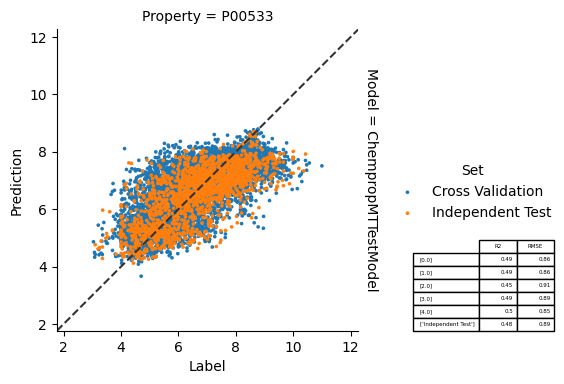

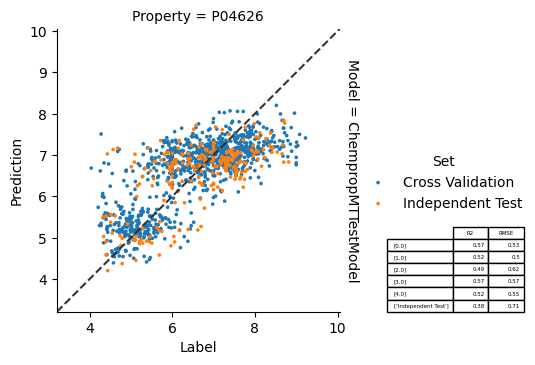

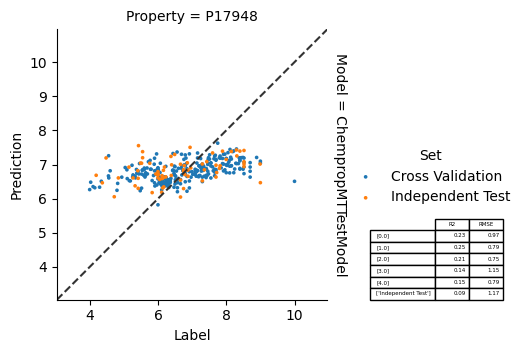

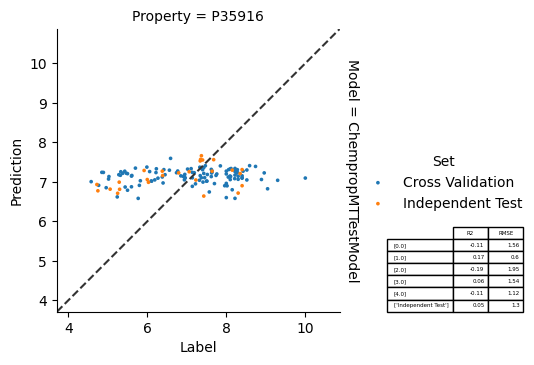

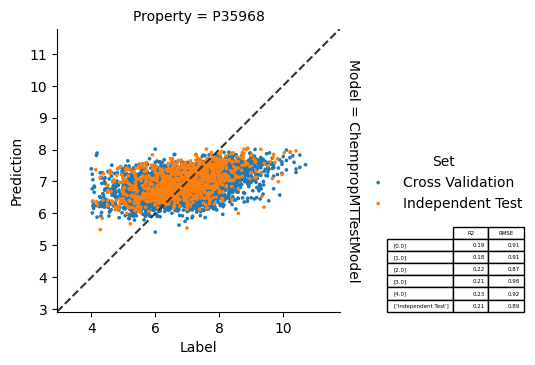

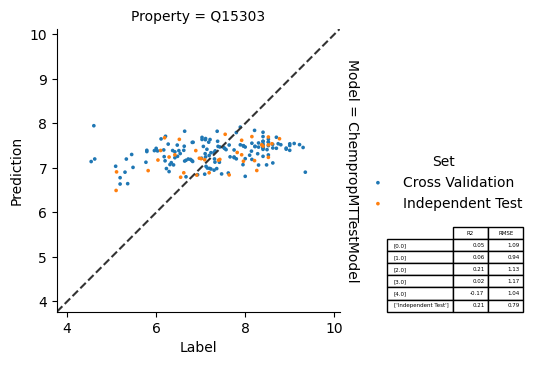

In [17]:
from plotting_regression_MT import CorrelationPlot

plot = CorrelationPlot([model])
axes, summary = plot.make(save=True, show=True, out_path='/home/s2861704/ppk/test_kin/test_output/ChempropMT.png')

In [ ]:
summary